In [3]:
import sys
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import tqdm
from collections import defaultdict


sys.path.append("../../")
from phenixml.fragments.fragments import Fragment, MolContainer
from phenixml.fragmentation.fragmenters import FragmenterBase, BondFragmenter, AngleFragmenter
from phenixml.labelers.fragment_labelers import BondFragmentLabeler,AngleFragmentLabeler
from phenixml.featurizers.atom_featurizers import RDKIT_Fingerprint

from phenixml.graphs.molgraph import MolGraph
from phenixml.graphs.molgraph_dataset import MolGraphDataset

from phenixml.utils.torch_utils import to_np
from phenixml.visualization.plotting import plot_geom_eval
from phenixml.visualization.fragment_display import FragmentDisplay
show = FragmentDisplay()

Using backend: pytorch


In [4]:
# get molecules
mol_dir = "/dev/shm/cschlick/geostd_passed/"
containers = MolContainer.from_folder(mol_dir,suffix=".mol",removeHs=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16151/16151 [00:39<00:00, 413.62it/s]


In [15]:
class NonbondedFragmenter(FragmenterBase):
  """
  Return the nonbonded pair fragments for a molecule
  Heuristics for nonbonded: 
    1. Within 3.5 angstrom radius
    2. Not within 2 radius bonded distance
  """

  def fragment(self,container):
    assert isinstance(container,MolContainer)
    
    
    # rdkit
    from phenixml.utils.rdkit_utils import enumerate_bonds
    from sklearn.neighbors import KDTree
    import networkx as nx

    bond_edges = enumerate_bonds(container.rdkit_mol)
    xyz = container.xyz
    tree = KDTree(xyz)
    inds = tree.query_radius(xyz,r=3.5)


    G = nx.Graph(list(bond_edges))

    connected_partners = dict(nx.all_pairs_shortest_path_length(G,cutoff=2)) 

    nonbonded_proxies = []
    for atom_i, partners in enumerate(inds):
      if atom_i in connected_partners:
        for partner in partners[1:]:
          if partner not in connected_partners[atom_i]:
            nonbonded_proxies.append([atom_i,partner])
            

    fragments = [Fragment(container,atom_selection=idx) for idx in nonbonded_proxies]
    return fragments

In [17]:
# fragment, featurize,label, build graphs
molgraphs = MolGraph.from_containers(containers,
                         fragmenter=BondFragmenter(exclude_elements=[]),
                         labeler=BondFragmentLabeler(),
                         nonbonded_fragmenter=NonbondedFragmenter(),
                                     skip_failures=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16150/16150 [06:35<00:00, 40.79it/s]


In [18]:
# set up dataset, train/test split
dataset= MolGraphDataset(molgraphs)
dataset_train, dataset_test = dataset.train_test_split(test_fraction=0.2)
batches = list(dataset_train.batches(batch_size=10000))

In [24]:
# make model
from phenixml.models.message_passing import MessagePassing
from phenixml.models.readout import ReadoutLinearJanossy

# settings
gpuid = 0
n_units = 128
n_layers_mp = 3
fragment_size = 2
feature_units = molgraphs[0].heterograph.nodes["atom"].data["h0"].shape[1]


# Set up message passing bonded
config = []
for n_layer in range(n_layers_mp):
  config+=[n_units,"relu"]

message_passing_bonded = MessagePassing(
    feature_units=feature_units,
    config=config) 

# Set up message passing nonbonded
config = []
for n_layer in range(n_layers_mp):
  config+=[n_units,"relu"]

message_passing_nonbonded = MessagePassing(
    feature_units=feature_units,
    config=config,
    edge_types=["nonbonded"]) 



# Set up readout
n_layers_readout = 3
config = []
for n_layer in range(n_layers_readout):
  config+=[64,"relu"]
  
readout = ReadoutLinearJanossy(
    in_features=n_units, 
    config=config,
    out_features={"pred":1},
    fragment_size = fragment_size)

# Sequential message passing, readout
model = nn.Sequential(message_passing_nonbonded,readout)
opt = torch.optim.Adam(model.parameters(),lr=1e-4)
metric = torch.nn.MSELoss()

if gpuid is not None:
  model = model.to("cuda:"+str(gpuid))

In [25]:
# Training loop
epoch_losses = []
n_epoch=2000

for epoch in tqdm.tqdm(range(n_epoch)):
  batch_losses = []
  for batch in batches:
    if gpuid is not None:
      batch = batch.to("cuda:"+str(gpuid))
    g = model(batch)
    loss = metric(g.nodes["fragment"].data["ref"],
                  g.nodes["fragment"].data["pred"])
    opt.zero_grad()
    loss.backward()
    opt.step()
    batch_losses.append(loss.item())

  epoch_losses.append(np.mean(batch_losses))
  


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [06:52<00:00,  4.85it/s]


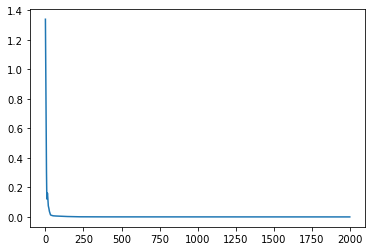

In [26]:
plt.plot(epoch_losses)

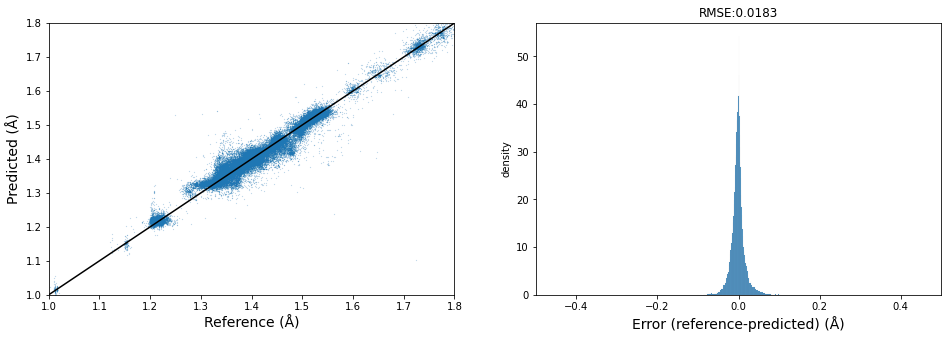

In [27]:
if gpuid is not None:
  model = model.to("cpu")
test_batch = model(dataset_test.heterograph)
a,b = (test_batch.nodes["fragment"].data["ref"], 
       test_batch.nodes["fragment"].data["pred"])
a,b = to_np(a).flatten(),to_np(b).flatten()
plot_geom_eval(a,b,mode="bond")

In [32]:
# evaluate
mol_containers = defaultdict(list)
for i,fragment in enumerate(dataset_test.fragments):
  
  ref,pred = (test_batch.nodes["fragment"].data["ref"][i].item(),
              test_batch.nodes["fragment"].data["pred"][i].item())
  error = np.abs(ref-pred)
  mol_containers[fragment.mol_container].append(error)
  
worst = np.array([np.max(value) for key,value in mol_containers.items()])
cutoff = 0.1
n_ok = (worst<=cutoff).sum()
n_bad = (worst>cutoff).sum()
print("Number of mols in test set:",len(mol_containers))
print("Mols better than cutoff:",n_ok)
print("Mols worse than cutoff:",n_bad)

Number of mols in test set: 3228
Mols better than cutoff: 3155
Mols worse than cutoff: 73
